# Pipeline

This pipeline includes all steps in a single notebook (For Google Colab setup and testing purposes). It is currently a work-in-progress, for now, please visit ./notebooks for the individual steps.

In [1]:
import sys

CURRENT_ENVIRONMENT = "GOOGLE_COLAB" if "google.colab" in sys.modules else "LOCAL"

In [2]:
import os
import shutil

if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # If the utils directory exists, delete it
    if os.path.exists('/content/utils'):
        shutil.rmtree('/content/utils')

    # Copy the utils.zip file to the current directory
    !cp /content/drive/MyDrive/utils.zip /content/utils.zip

    # Unzip the utils.zip file
    !unzip -q /content/utils.zip -d /content/utils

    # Delete the utils.zip file
    !rm /content/utils.zip

In [3]:
if CURRENT_ENVIRONMENT == "LOCAL":
    from utils.constants import *
elif CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from utils.constants_colab import *

In [4]:
import os
from utils.zipper import read_file, write_file

install_file = os.path.join(DATA_DIR, "install.txt")

# Create the directory if it does not exist
os.makedirs(DATA_DIR, exist_ok=True)

install_content = read_file(install_file)

if ENVIRONMENT == "LOCAL":
    requirements_file = "requirements.txt"
    requirements_content = read_file(requirements_file)
    if install_content != requirements_content:
        get_ipython().system("pip install -r requirements.txt")
        write_file(install_file, requirements_content)
elif ENVIRONMENT == "GOOGLE_COLAB":
    if install_content != "imagehash":
        get_ipython().system("pip install imagehash")
        write_file(install_file, "imagehash")

In [5]:
if ENVIRONMENT == "LOCAL":
    from utils.cache import reload_custom_libraries

    # Refresh library cache
    reload_custom_libraries()

In [6]:
if ENVIRONMENT == "LOCAL":
    from utils.zipper import zip_dir

    # Zip the reloaded libraries to be used in Google Colab
    zip_dir(UTILS_DIR, f"{ZIPPED_RESOURCES_DIR}/utils.zip")

In [7]:
from utils.zipper import unzip_file

# Check if the zipped preprocessed datasets file exists and ROOT_DATASET_DIR does not exist
if os.path.exists(PREPROCESSED_DATASETS_ZIP):
    print("Cached preprocessed datasets found.")
    if not os.path.exists(ROOT_DATASET_DIR):
        print("Extracting preprocessed datasets...")
        unzip_file(
            PREPROCESSED_DATASETS_ZIP,
            PREPROCESSED_DATASETS_EXTRACT_DIR,
        )
        print("Preprocessed datasets extracted.")
    else:
        print("Directory with preprocessed datasets found. Skipping extraction...")
else:
    print("Cached preprocessed datasets not found. Skipping extraction...")

Cached preprocessed datasets found.
Directory with preprocessed datasets found. Skipping extraction...


In [8]:
from utils.converter import convert_to_df


train_df = convert_to_df(DATASET_DIR, TRAIN_DATA_CSV)
cleaned_train_df = convert_to_df(CLEANED_DATASET_DIR, CLEANED_TRAIN_DATA_CSV)
processed_train_df = convert_to_df(PROCESSED_DATASET_DIR, PROCESSED_TRAIN_DATA_CSV)

CSV file already exists at ./data/datasets/raw.csv. Loading from cache...
CSV file already exists at ./data/datasets/cleaned.csv. Loading from cache...
CSV file already exists at ./data/datasets/processed.csv. Loading from cache...


In [9]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print(
    "GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
)

TF version: 2.10.1
Hub version: 0.16.1
GPU is available


In [10]:
from tqdm.notebook import tqdm
import zipfile
import shutil
import os

# if force unzip or DATASET_DIR doesn't exist or empty
if FORCE_UNZIP or not tf.io.gfile.exists(DATASET_DIR):
    if not os.path.isdir(f"{DATASET_EXTRACT_DIR}/Furniture_Data"):
        print("Starting unzip process...")
        # Extract the zip file
        with zipfile.ZipFile(RAW_DATASET_ZIP, "r") as zip_ref:
            zip_ref.extractall(DATASET_EXTRACT_DIR)
        print("Unzip process completed.")

        print("Checking for `__MACOSX` directory...")
        # Check if the `__MACOSX` directory exists
        if os.path.isdir(MACOS_DIR):
            # Delete the `__MACOSX` directory
            shutil.rmtree(MACOS_DIR)
            print("`__MACOSX` directory found and deleted.")
        else:
            print("`__MACOSX` directory not found. Skipping deletion.")

        if ENVIRONMENT == "GOOGLE_COLAB":
            # Check if the new dataset already directory exists
            print("Checking for existing train dataset directory...")
            if os.path.isdir(DATASET_DIR):
                # Delete the new dataset directory
                shutil.rmtree(DATASET_DIR)
                print("Existing train dataset directory found and deleted.")

            # Move the extracted dataset to the correct directory
            if os.path.isdir(f"{DATASET_EXTRACT_DIR}/Furniture_Data"):
                print("Moving extracted dataset to the correct directory...")
                shutil.move(f"{DATASET_EXTRACT_DIR}/Furniture_Data", ROOT_DATASET_DIR)
                print("Dataset moved successfully.")
        elif ENVIRONMENT == "LOCAL":
            # Rename the extracted directory to the correct directory
            if os.path.isdir(f"{DATASET_EXTRACT_DIR}/Furniture_Data"):
                print("Renaming extracted dataset directory...")
                os.rename(f"{DATASET_EXTRACT_DIR}/Furniture_Data", DATASET_DIR)
                print("Dataset renamed successfully.")
else:
    print("Skipping unzip process as DATASET_DIR exists and FORCE_UNZIP is not set.")

Skipping unzip process as DATASET_DIR exists and FORCE_UNZIP is not set.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
from PIL import Image
from PIL import ImageFile
import os, sys
from tqdm.notebook import tqdm
from utils.image_process import (
    get_category_styles,
    process_images,
    get_category_image_paths,
    resize_images,
    get_majority_class,
    identify_minority_classes,
    calculate_category_oversampling,
    calculate_style_oversampling,
    oversample_minority_classes,
)

In [12]:
data = tf.keras.utils.image_dataset_from_directory(DATASET_DIR)

Found 90082 files belonging to 6 classes.


In [13]:
categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]
paths = {
    category: get_category_image_paths(DATASET_DIR, category) for category in categories
}
print("Successfully extracted all paths!")

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths!


In [14]:
# Calculate the total
total = 0

# Print the amount for each category
for category in categories:
    amount = len(paths[category])
    print(f"Amount of {category}: {amount}")
    total += amount

# Print the total
print("Total:", total)

Amount of beds: 6578
Amount of chairs: 22053
Amount of dressers: 7870
Amount of lamps: 32402
Amount of sofas: 4080
Amount of tables: 17100
Total: 90083


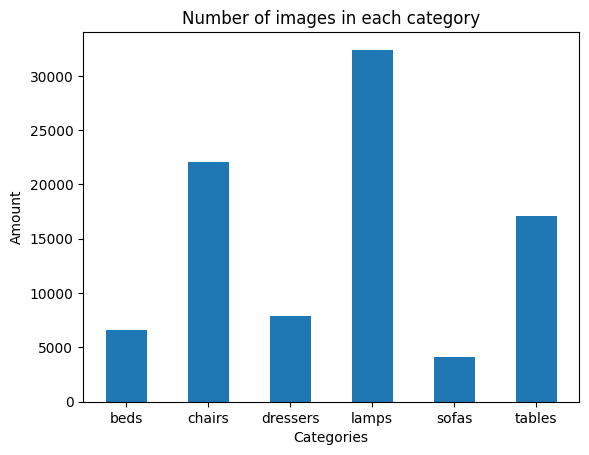

In [15]:
plt.bar(paths.keys(), [len(v) for v in paths.values()], width=0.5)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")
plt.show()

## Get duplicate images from each categories
### Check duplicants and remove duplicants from each categories

In [16]:
# Create a new dictionary to store the paths and image sizes for each category
data = {}
for category, items in paths.items():
    imageSizes = process_images(items, category, DATASET_DIR)
    data[category] = {
        "paths": get_category_image_paths(CLEANED_DATASET_DIR, category),
        "imageSizes": imageSizes,
    }

paths = {
    category: get_category_image_paths(CLEANED_DATASET_DIR, category)
    for category in categories
}

print("Successfully extracted all paths and image sizes!")

Loaded image sizes from cache.
(350, 350) pixels:  41
(224, 224) pixels:  6537
Category 'beds', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', S

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  22053
Category 'chairs', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  7870
Category 'dressers', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  32401
Category 'lamps', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Midcent

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  4080
Category 'sofas', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Midcentu

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  17099
(500, 446) pixels:  1
Category 'tables', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Ca

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths and image sizes!


### Recheck the categories after removing duplicants

In [17]:
# Calculate the total
total = 0

# Print the amount for each category
for category in categories:
    amount = len(data[category]["paths"])
    print(f"Amount of {category}: {amount}")
    total += amount

# Print the total
print("Total:", total)

Amount of beds: 6542
Amount of chairs: 20069
Amount of dressers: 6650
Amount of lamps: 22981
Amount of sofas: 3384
Amount of tables: 16071
Total: 75697


### Visualization

Text(0, 0.5, 'Amount')

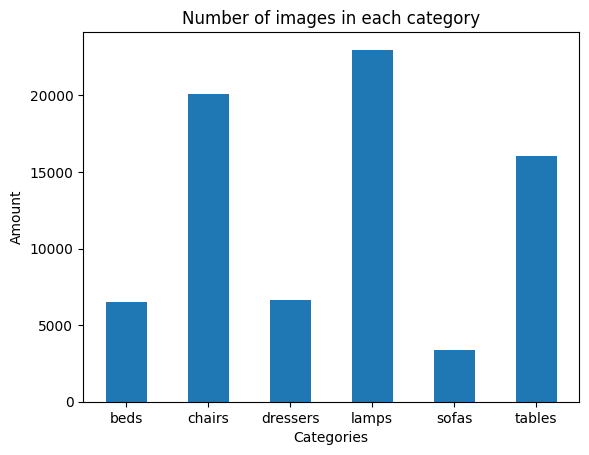

In [18]:
plt.bar(
    categories, [len(data[category]["paths"]) for category in categories], width=0.5
)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")

-   In the plot we can see the differences between of the amount in different columns. Because of that, we will need to check for the imbalances of our dataset

## Get different amount of image size of each category

In [19]:
# Define a dictionary to store the dataframes
# each category in df_dims is data[category][imageSizes]
df_dims = {
    category: pd.DataFrame(data[category]["imageSizes"], columns=["width", "height"])
    for category in categories
}

print("Successfully extracted all dimensions!")

Successfully extracted all dimensions!


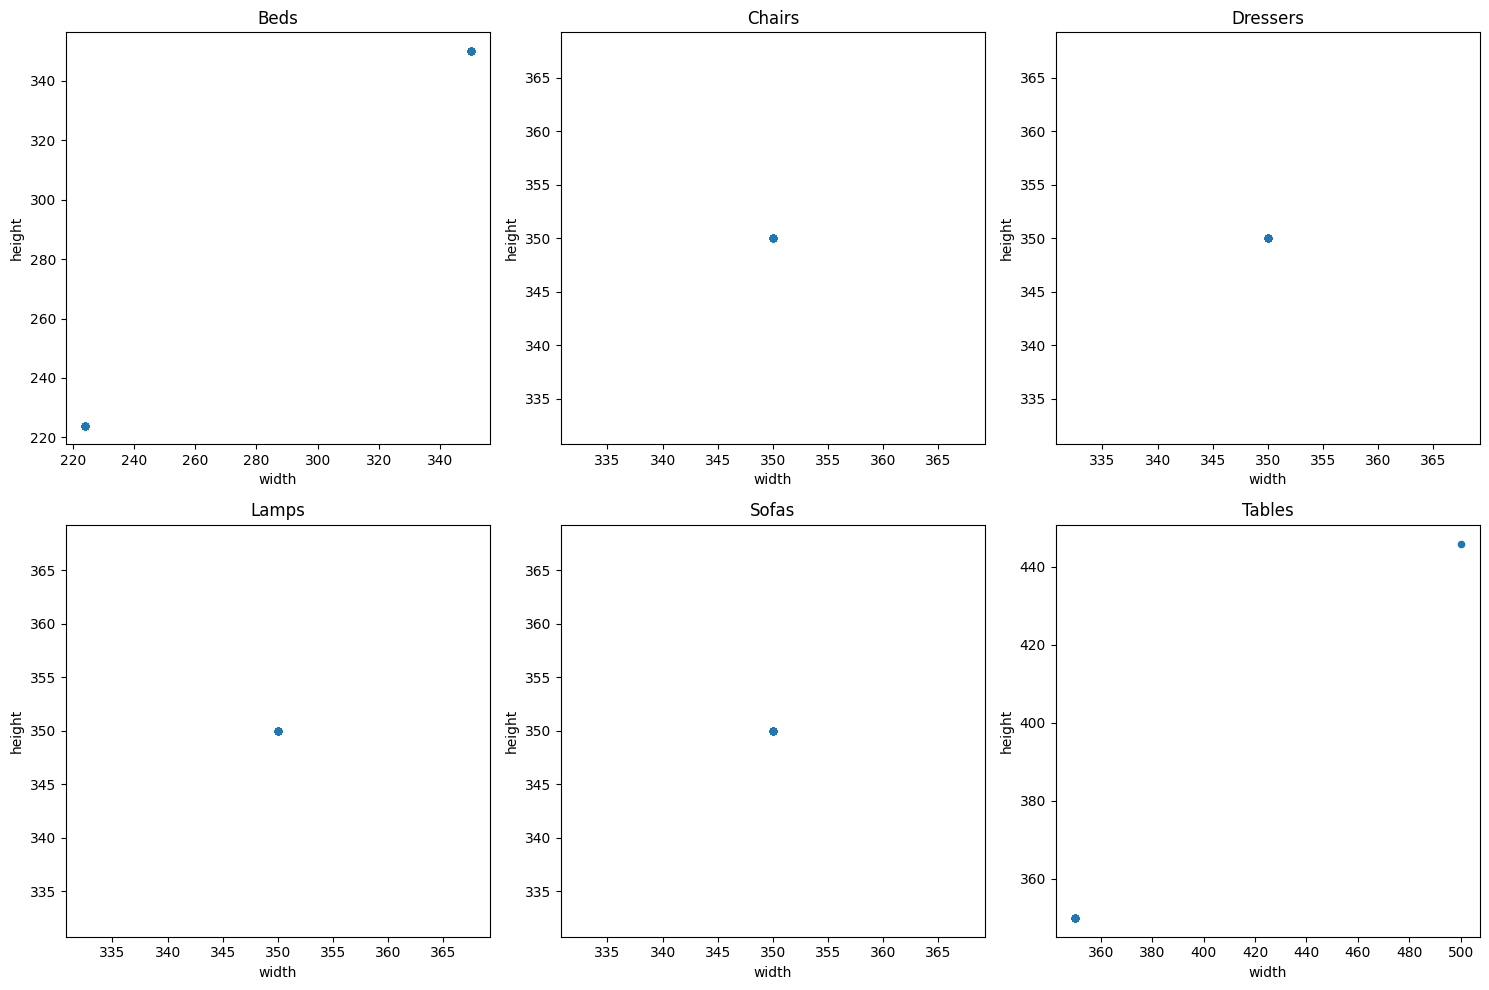

In [20]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplot grid
n_rows = 2
n_cols = 3

# Create the subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Flatten the axes array
axs = axs.flatten()

# Iterate over the categories and axes
for ax, category in zip(axs, categories):
    # Create the scatter plot for the current category
    df_dims[category].plot.scatter(
        x="width", y="height", ax=ax, title=category.capitalize()
    )

# Adjust the layout
plt.tight_layout()
plt.show()

In [21]:
# Iterate over the categories
for category in categories:
    print(category.capitalize())
    display(df_dims[category].describe().T)

Beds


,count,mean,std,min,25%,50%,75%,max
width,6578.0,224.785345,9.917241,224.0,224.0,224.0,224.0,350.0
height,6578.0,224.785345,9.917241,224.0,224.0,224.0,224.0,350.0


Chairs


,count,mean,std,min,25%,50%,75%,max
width,22053.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,22053.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Dressers


,count,mean,std,min,25%,50%,75%,max
width,7870.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,7870.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Lamps


,count,mean,std,min,25%,50%,75%,max
width,32401.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,32401.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Sofas


,count,mean,std,min,25%,50%,75%,max
width,4080.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,4080.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Tables


,count,mean,std,min,25%,50%,75%,max
width,17100.0,350.008772,1.147079,350.0,350.0,350.0,350.0,500.0
height,17100.0,350.005614,0.734130,350.0,350.0,350.0,350.0,446.0


- The dataset contains 6 categories of items with 90083 items total
- The dataset contains all file with JPEG type
- The dataset contains image mainly in two dimensions: 224x224 and 350x350. However there are one anomaly dimensions in the table category which is: 500x446

## Data Preprocessing

We will start with resizing all images to 350x350. Here are some reasons:
- The vast majority of the images are already at 350x350. Upscaling the smaller images will introduce minimal distortion compared to downscaling the majority to 224x224.
- Upscaling generally retains more information from the original image than downscaling. While some interpolation artifacts might be introduced, they are less likely to significantly impact model performance compared to the information loss from downscaling.
- The single image with a size of 500x448 is an outlier. which we can either upscale it to match the majority or exclude it from our dataset without significant impact.

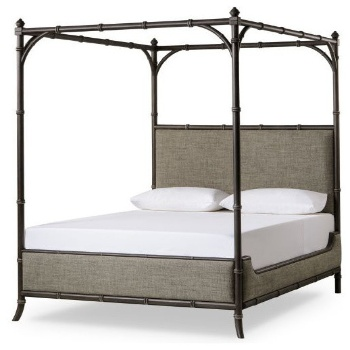

In [22]:
Image.open(data["beds"]["paths"][1])

In [23]:
for category in categories:
    print(f"Number of images in category '{category}': {len(data[category]['paths'])}")

# Total number of images
total = sum(len(data[category]["paths"]) for category in categories)
print(f"Total number of images: {total}")

Number of images in category 'beds': 6542
Number of images in category 'chairs': 20069
Number of images in category 'dressers': 6650
Number of images in category 'lamps': 22981
Number of images in category 'sofas': 3384
Number of images in category 'tables': 16071
Total number of images: 75697


In [24]:
# check all file extensions in data[*]["paths"]
for category in categories:
    print(f"Checking file extensions for category '{category}'")
    for img_path in data[category]["paths"]:
        if not img_path.endswith((".jpg", ".jpeg", ".png")):
            print(f"Invalid file extension: {img_path}")
            break
    print(f"All file extensions are valid for category '{category}'")

Checking file extensions for category 'beds'
All file extensions are valid for category 'beds'
Checking file extensions for category 'chairs'
All file extensions are valid for category 'chairs'
Checking file extensions for category 'dressers'
All file extensions are valid for category 'dressers'
Checking file extensions for category 'lamps'
All file extensions are valid for category 'lamps'
Checking file extensions for category 'sofas'
All file extensions are valid for category 'sofas'
Checking file extensions for category 'tables'
All file extensions are valid for category 'tables'


In [25]:
size = (350, 350)

for category in data.keys():
    resize_images(data, category, size)

In [26]:
# Display the minority classes
majority_class, max_count = get_majority_class(data)
minority_classes = identify_minority_classes(data, 1.0)

# Display the classes
print("Majority class:", majority_class)
print("Minority classes:", minority_classes)

Majority class: lamps
Minority classes: ['beds', 'chairs', 'dressers', 'sofas', 'tables']


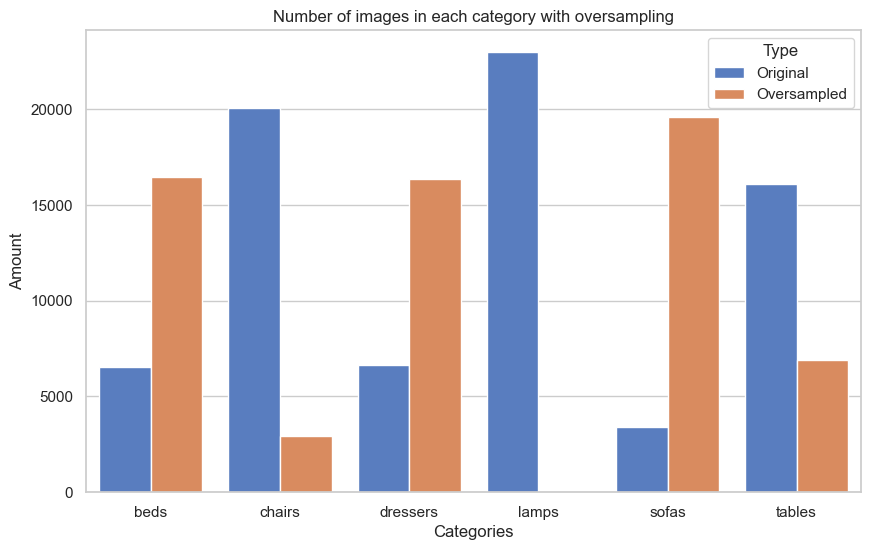

Total number of images before oversampling: 75697
Total number of images after oversampling: 137886


In [27]:
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# calculate the how much oversampling is needed
oversampling = calculate_category_oversampling(
    data, minority_classes + [majority_class], max_count
)

# Visualize the data
categories = list(data.keys())
original_counts = [len(data[category]["paths"]) for category in categories]
oversampled_counts = [oversampling.get(category, 0) for category in categories]

# Create DataFrame for seaborn
df = pd.DataFrame(
    {
        "Category": categories,
        "Original": original_counts,
        "Oversampled": oversampled_counts,
    }
)

# Melt DataFrame
df_melt = df.melt(id_vars="Category", var_name="Type", value_name="Count")

# Create barplot
plt.figure(figsize=(10, 6))
sns.barplot(x="Category", y="Count", hue="Type", data=df_melt, palette="muted")

# Add some text for labels, title and axes ticks
plt.title("Number of images in each category with oversampling")
plt.xlabel("Categories")
plt.ylabel("Amount")

plt.show()

print("Total number of images before oversampling:", sum(original_counts))
print(
    "Total number of images after oversampling:",
    sum(original_counts) + sum(oversampled_counts),
)

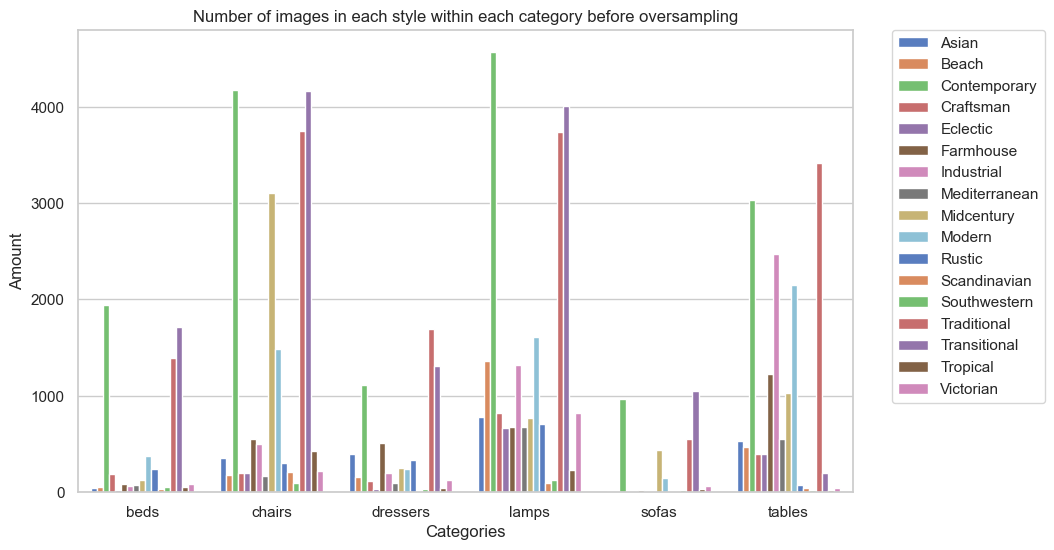

In [28]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Prepare data for visualization
categories, styles, original_counts = [], [], []

for category, paths in data.items():
    style_counts = {}
    for path in paths["paths"]:
        # Extract style from the path
        style = os.path.dirname(path).split("/")[-1]
        if style not in style_counts:
            style_counts[style] = 0
        style_counts[style] += 1

    for style, count in style_counts.items():
        categories.append(category)
        styles.append(style)
        original_counts.append(count)

# Create DataFrame for seaborn
df = pd.DataFrame(
    {
        "Category": categories,
        "Style": styles,
        "Original": original_counts,
    }
)

# Melt DataFrame
df_melt = df.melt(id_vars=["Category", "Style"], var_name="Type", value_name="Count")

# Create barplot
plt.figure(figsize=(10, 6))
sns.barplot(x="Category", y="Count", hue="Style", data=df_melt, palette="muted")

# Add some text for labels, title and axes ticks
plt.title("Number of images in each style within each category before oversampling")
plt.xlabel("Categories")
plt.ylabel("Amount")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

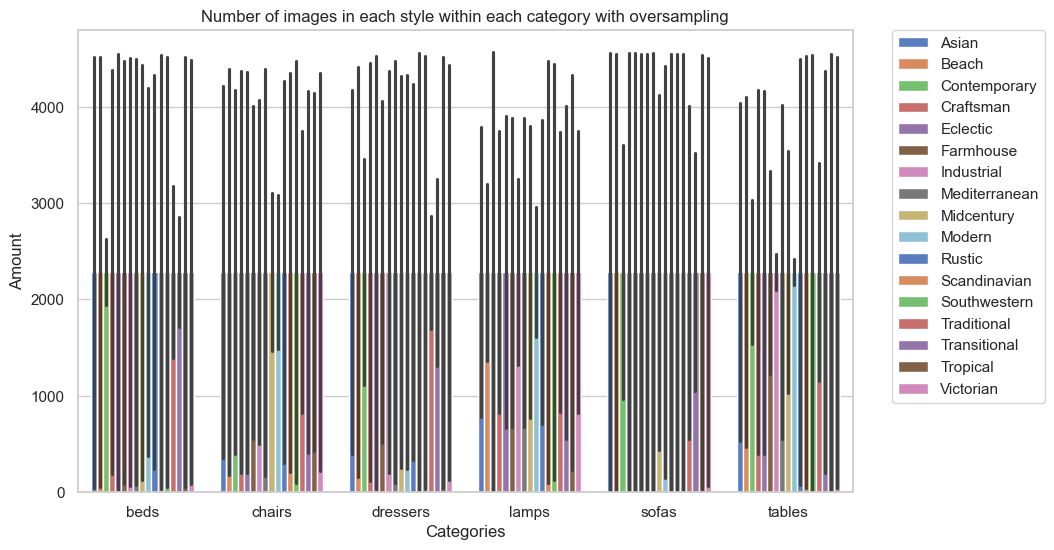

In [29]:
# Set the style of seaborn
sns.set(style="whitegrid")

# calculate the how much oversampling is needed
oversampling = calculate_style_oversampling(data, minority_classes + [majority_class])

# Prepare data for visualization
categories, styles, original_counts, oversampled_counts = [], [], [], []

for category, paths in data.items():
    style_counts = {}
    for path in paths["paths"]:
        # Extract style from the path
        style = os.path.dirname(path).split("/")[-1]
        if style not in style_counts:
            style_counts[style] = 0
        style_counts[style] += 1

    for style, count in style_counts.items():
        categories.append(category)
        styles.append(style)
        original_counts.append(count)
        oversampled_counts.append(oversampling.get(category, {}).get(style, 0))

# Create DataFrame for seaborn
df = pd.DataFrame(
    {
        "Category": categories,
        "Style": styles,
        "Original": original_counts,
        "Oversampled": oversampled_counts,
    }
)

# Melt DataFrame
df_melt = df.melt(id_vars=["Category", "Style"], var_name="Type", value_name="Count")

# Create barplot
plt.figure(figsize=(10, 6))
sns.barplot(x="Category", y="Count", hue="Style", data=df_melt, palette="muted")

# Add some text for labels, title and axes ticks
plt.title("Number of images in each style within each category with oversampling")
plt.xlabel("Categories")
plt.ylabel("Amount")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

Projected sum for category 'beds': 77639
Projected sum for category 'chairs': 77639
Projected sum for category 'dressers': 77639
Projected sum for category 'lamps': 77639
Projected sum for category 'sofas': 77639
Projected sum for category 'tables': 77639


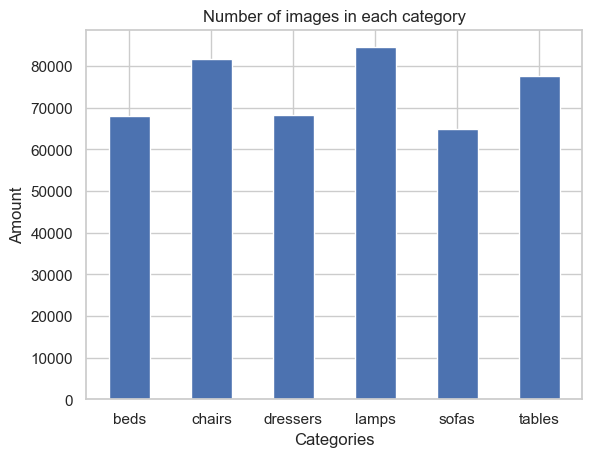

In [30]:
# print all projected sum to check if all categories have roughly the same amount of images
categories = list(data.keys())
for category in categories:
    oversampling_count = sum(oversampling.get(category, {}).values())
    print(
        f"Projected sum for category '{category}':",
        len(data[category]["paths"]) + oversampling_count,
    )

# Create a bar chart of the number of images in each category
plt.bar(
    categories,
    [len(data[category]["paths"]) + oversampling_count for category in categories],
    width=0.5,
)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")
plt.show()

In [31]:
print("Total number of images before oversampling:", sum(original_counts))
print(
    "Total number of images after oversampling:",
    sum(original_counts) + sum(oversampled_counts),
)

Total number of images before oversampling: 75697
Total number of images after oversampling: 465834


In [32]:
# Oversample minority classes
data = oversample_minority_classes(data, minority_classes + [majority_class])

# Calculate the total
total = 0
# Print the amount for each category
for category in categories:
    amount = len(data[category]["paths"])
    print(f"Amount of {category}: {amount}")
    total += amount

# Print the total
print("Total:", total)

Oversampling minority classes:   0%|          | 0/390137 [00:00<?, ?it/s]

Amount of beds: 6542
Amount of chairs: 20069
Amount of dressers: 6650
Amount of lamps: 22981
Amount of sofas: 3384
Amount of tables: 16071
Total: 75697


Text(0, 0.5, 'Amount')

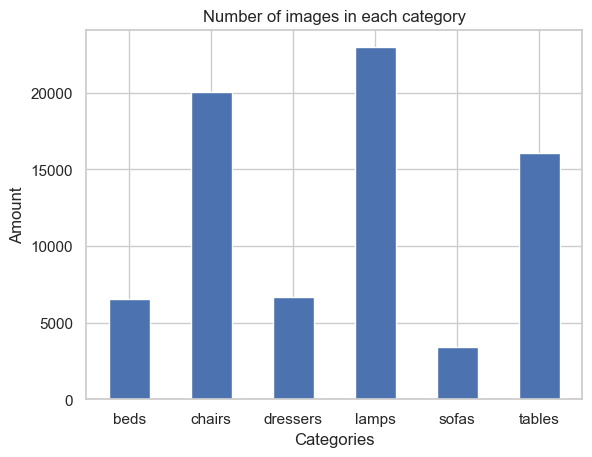

In [33]:
plt.bar(
    categories, [len(data[category]["paths"]) for category in categories], width=0.5
)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")

In [34]:
paths = {
    category: get_category_image_paths(PROCESSED_DATASET_DIR, category)
    for category in categories
}

for category, items in paths.items():
    imageSizes = process_images(items, category, PROCESSED_DATASET_DIR)
    data[category] = {
        "paths": get_category_image_paths(PROCESSED_DATASET_DIR, category),
        "imageSizes": imageSizes,
    }

print("Successfully extracted all paths and image sizes!")

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  8030
(224, 224) pixels:  69609
Category 'beds', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds'

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  77639
Category 'chairs', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  77639
Category 'dressers', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  77639
Category 'lamps', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Midcent

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  77639
Category 'sofas', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Midcent

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  77471
(500, 446) pixels:  168
Category 'tables', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.


Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths and image sizes!


In [35]:
from utils.converter import convert_to_df, prepare_data_for_training

train_df = convert_to_df(DATASET_DIR, TRAIN_DATA_CSV)
cleaned_train_df = convert_to_df(CLEANED_DATASET_DIR, CLEANED_TRAIN_DATA_CSV)
processed_train_df = convert_to_df(PROCESSED_DATASET_DIR, PROCESSED_TRAIN_DATA_CSV)

# prepare_data_for_training(PROCESSED_DATASET_DIR)

CSV file already exists at ./data/datasets/raw.csv. Loading from cache...
CSV file already exists at ./data/datasets/cleaned.csv. Loading from cache...
CSV file already exists at ./data/datasets/processed.csv. Loading from cache...


In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_df, test_df = train_test_split(
    processed_train_df,
    test_size=0.2,
    random_state=42,
    stratify=processed_train_df[["Category", "Style"]],
)

# Split the train set into train and validation sets
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,
    random_state=42,
    stratify=train_df[["Category", "Style"]],
)

# Create a data generator
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load images from dataframes for Category classification
train_generator_category = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Full_Path",
    y_col="Category",
    target_size=(350, 350),
    batch_size=32,
    class_mode="sparse",
)

val_generator_category = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Full_Path",
    y_col="Category",
    target_size=(350, 350),
    batch_size=32,
    class_mode="sparse",
)

test_generator_category = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Full_Path",
    y_col="Category",
    target_size=(350, 350),
    batch_size=32,
    class_mode="sparse",
)

# Load images from dataframes for Style classification
train_generator_style = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Full_Path",
    y_col="Style",
    target_size=(350, 350),
    batch_size=32,
    class_mode="sparse",
)

val_generator_style = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Full_Path",
    y_col="Style",
    target_size=(350, 350),
    batch_size=32,
    class_mode="sparse",
)

test_generator_style = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Full_Path",
    y_col="Style",
    target_size=(350, 350),
    batch_size=32,
    class_mode="sparse",
)

Found 279500 validated image filenames belonging to 6 classes.
Found 93167 validated image filenames belonging to 6 classes.
Found 93167 validated image filenames belonging to 6 classes.
Found 279500 validated image filenames belonging to 17 classes.
Found 93167 validated image filenames belonging to 17 classes.
Found 93167 validated image filenames belonging to 17 classes.


In [37]:
# Set to True if you want to train all models,
# otherwise set to False to save time
TRAIN_ALL_MODELS = False

# Recommended to set to an empty array ([]) to avoid retraining models,
# in case you want to retrain any model, add the model name to the array
MODELS_TO_RETRAIN = []

### Task 1:

#### Model 1: Convolutional Neural Network (CNN) Model

Convolutional Neural Networks (CNNs) are a class of deep learning models that are primarily used for analyzing visual data. CNNs are particularly effective for tasks such as image classification, object detection, and facial recognition.

The CNN model in this code is a simple yet effective architecture for image classification. It consists of two convolutional layers, each followed by a max pooling layer, a flattening layer, and two dense layers.

The convolutional layers are the first layers of the network, where the model learns several high-level features of the images. Each convolutional layer in this model uses a 3x3 kernel and a ReLU (Rectified Linear Unit) activation function. The 'same' padding is used to preserve the spatial dimensions of the volume such that the output volume size matches the input volume size.

The max pooling layers are used to reduce the spatial dimensions of the output volume. It is a down-sampling operation that is performed after each convolutional layer to reduce the dimensionality and to prevent overfitting.

The flattening layer is used to convert the 2D matrix into a 1D vector, which can be fed into the dense layers.

The dense layers, also known as fully connected layers, perform classification on the features extracted by the convolutional layers and down-sampled by the max pooling layers. The final dense layer uses a softmax activation function to output a probability distribution over the 6 classes of furniture.

The model is trained using the Adam optimizer and the sparse categorical cross-entropy loss function, which is suitable for multi-class classification problems. The model's performance is evaluated using accuracy as the metric.

The model is trained on a training dataset and validated on a validation dataset. After training, the model is saved to a file and then evaluated on a test dataset to measure its performance.

In [38]:
MODEL_NAME = "task_1_CNN_model"
FORCE_TRAIN = True

# Check if MODEL_NAME is in MODELS_TO_RETRAIN
if FORCE_TRAIN or MODEL_NAME in MODELS_TO_RETRAIN or TRAIN_ALL_MODELS:
    import os
    import csv
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras import layers, Sequential, models
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
    from tensorflow.keras.models import load_model

    # Load images from directories
    train_generator = train_generator_category
    val_generator = val_generator_category
    test_generator = test_generator_category

    # Define the CNN model
    model = Sequential(
        [
            layers.Conv2D(
                32,
                (3, 3),
                activation="relu",
                padding="same",
                input_shape=(350, 350, 3),
            ),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.5),  # Add dropout for regularization
            layers.Dense(6, activation="softmax"),  # 6 classes of furniture
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Callbacks
    checkpoint = ModelCheckpoint(
        filepath=f"{MODEL_DIR}/{MODEL_NAME}_at_epoch_" + "{epoch:02d}.h5",
        monitor="val_accuracy",
        mode="max",
        verbose=1,
        save_weights_only=False,
        save_freq="epoch",
    )
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )
    csv_logger = CSVLogger(f"{MODEL_DIR}/{MODEL_NAME}_training_log.csv")
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=2, min_lr=0.00001
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr],
    )

    # If environment is Google Colab, copy the model file to Google Drive
    if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
        shutil.copy2(model_file, f"{GOOGLE_DRIVE_ROOT_DIR}/{MODEL_NAME}")

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print("Test accuracy:", test_acc)

Epoch 1/10
8735/8735 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.7831
Epoch 1: saving model to ./cache/models\task_1_CNN_model_at_epoch_01.h5
8735/8735 [==============================] - 1611s 184ms/step - loss: 0.6226 - accuracy: 0.7831 - val_loss: 0.3329 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 2/10
 348/8735 [>.............................] - ETA: 16:05 - loss: 0.3131 - accuracy: 0.8968

KeyboardInterrupt: 

#### Model 2: EfficientNetB0

EfficientNet is a family of convolutional neural network (CNN) architectures that were introduced by Google AI researchers in 2019. The primary goal of EfficientNet models is to provide high-performance CNN architectures that are also efficient in terms of computational resources and the number of parameters.

The EfficientNet family includes several variants, from EfficientNetB0 to EfficientNetB7, each providing a different trade-off between accuracy and computational efficiency. These models were obtained by systematically scaling up the baseline model (EfficientNetB0) in terms of depth, width, and resolution.

EfficientNetB0 is the smallest variant in the EfficientNet family. Despite its small size, it often outperforms larger models on various image classification tasks, thanks to its balanced and efficient architecture.

The EfficientNetB0 model is particularly suitable for applications where computational resources are limited, such as on mobile devices or in edge computing scenarios. It can also be used as a base model for transfer learning in a wide range of computer vision tasks.

Here's the code for implementing the EfficientNetB0 model:

In [ ]:
MODEL_NAME = "task_1_EfficientNetB0_model.h5"
FORCE_TRAIN = False

# Check if MODEL_NAME is in MODELS_TO_RETRAIN
if FORCE_TRAIN or MODEL_NAME in MODELS_TO_RETRAIN or TRAIN_ALL_MODELS:
    import os
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
    from tensorflow.keras.models import Model, load_model

    # Create data generators with data augmentation
    train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Load images from directories
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    val_generator = val_datagen.flow_from_directory(
        VAL_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    test_generator = val_datagen.flow_from_directory(
        TEST_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    # Define the model file path
    model_file = f"{MODEL_DIR}/{MODEL_NAME}"

    # If the model file exists, load the model from it
    if os.path.exists(model_file):
        model = load_model(model_file)
    else:
        # Load pre-trained EfficientNetB0 model without top layers
        base_model = EfficientNetB0(
            weights="imagenet", include_top=False, input_shape=(350, 350, 3)
        )

        # Add custom classification head
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation="relu")(x)
        predictions = Dense(6, activation="softmax")(x)  # 6 classes of furniture

        # Create the final model
        model = Model(inputs=base_model.input, outputs=predictions)

        # Freeze the base model layers (optional, you can experiment with fine-tuning)
        for layer in base_model.layers:
            layer.trainable = False

        # Compile the model
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Train the model
        history = model.fit(train_generator, epochs=10, validation_data=val_generator)

        # Save the model to the model file
        model.save(model_file)

        # If environment is Google Colab, copy the model file to Google Drive
        if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
            shutil.copy2(model_file, f"{GOOGLE_DRIVE_ROOT_DIR}/{MODEL_NAME}")

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print("Test accuracy:", test_acc)

#### Model 3: ResNet50

ResNet50 is a variant of ResNet, a convolutional neural network (CNN) architecture that introduced the concept of "residual learning" to address the problem of training very deep neural networks. The "50" in ResNet50 refers to the number of layers in this variant of the architecture.

ResNet50, like other ResNet models, uses "shortcut connections" (also known as "skip connections") that allow the gradient to be directly backpropagated to earlier layers. This helps to mitigate the problem of vanishing gradients, making it possible to train very deep networks.

In this code, the ResNet50 model is used for a multi-class image classification task. The model is trained on a dataset of images of furniture, with 6 different classes.

The model is implemented using the TensorFlow and Keras libraries. The base ResNet50 model is loaded without pre-trained weights, and a custom classification head is added on top of it. This classification head consists of a global average pooling layer, a dense layer with ReLU activation, and a final dense layer with softmax activation that outputs a probability distribution over the 6 classes.

The model is trained using the Adam optimizer and the sparse categorical cross-entropy loss function, which is suitable for multi-class classification problems. The model's performance is evaluated using accuracy as the metric.

The model is trained on a training dataset and validated on a validation dataset. After training, the model is saved to a file and then evaluated on a test dataset to measure its performance.

In [ ]:
MODEL_NAME = "task_1_ResNet50_model.h5"
FORCE_TRAIN = False

# Check if MODEL_NAME is in MODELS_TO_RETRAIN
if FORCE_TRAIN or MODEL_NAME in MODELS_TO_RETRAIN or TRAIN_ALL_MODELS:
    import os
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
    from tensorflow.keras.models import Model, load_model

    # Create data generators with data augmentation
    train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Load images from directories
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    val_generator = val_datagen.flow_from_directory(
        VAL_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    test_generator = val_datagen.flow_from_directory(
        TEST_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    # Define the model file path
    model_file = f"{MODEL_DIR}/{MODEL_NAME}"

    # If the model file exists, load the model from it
    if os.path.exists(model_file):
        model = load_model(model_file)
    else:
        # Load ResNet50 model without pre-trained weights (if retraining)
        base_model = ResNet50(
            weights=None, include_top=False, input_shape=(350, 350, 3)
        )

        # Add custom classification head
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation="relu")(x)
        predictions = Dense(6, activation="softmax")(x)  # 6 classes of furniture

        # Create the final model
        model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Train the model
        history = model.fit(train_generator, epochs=10, validation_data=val_generator)

        # Save the model to the model file
        model.save(model_file)

        # If environment is Google Colab, copy the model file to Google Drive
        if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
            shutil.copy2(model_file, f"{GOOGLE_DRIVE_ROOT_DIR}/{MODEL_NAME}")

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print("Test accuracy:", test_acc)

#### Model 4: Vision Transformer (ViT)

The Vision Transformer (ViT) is a transformer-based model that is used for image classification tasks. Unlike traditional convolutional neural networks (CNNs) that use convolutional layers to process image data, the ViT uses transformer layers to process image data in the form of sequences of patches.

In this code, the ViT model is used for a multi-class image classification task. The model is trained on a dataset of images of furniture, with 6 different classes.

The model is implemented using the TensorFlow and Keras libraries. The base ViT model is loaded with pre-trained weights, and a custom classification head is added on top of it. This classification head consists of a global average pooling layer, a dropout layer for regularization, a dense layer with ReLU activation, another dropout layer, and a final dense layer with softmax activation that outputs a probability distribution over the 6 classes.

The model is trained using the Adam optimizer and the sparse categorical cross-entropy loss function, which is suitable for multi-class classification problems. The model's performance is evaluated using accuracy as the metric.

The model is trained on a training dataset and validated on a validation dataset. After training, the model is saved to a file and then evaluated on a test dataset to measure its performance.

In [ ]:
MODEL_NAME = "task_1_ViT_model.h5"
FORCE_TRAIN = False

# Check if MODEL_NAME is in MODELS_TO_RETRAIN
if FORCE_TRAIN or MODEL_NAME in MODELS_TO_RETRAIN or TRAIN_ALL_MODELS:
    import os
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
    from tensorflow.keras.models import Model, load_model
    from vit_keras import vit, utils

    # Create data generators with data augmentation
    train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Load images from directories
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    val_generator = val_datagen.flow_from_directory(
        VAL_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    test_generator = val_datagen.flow_from_directory(
        TEST_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    # Define the model file path
    model_file = f"{MODEL_DIR}/{MODEL_NAME}"

    # If the model file exists, load the model from it
    if os.path.exists(model_file):
        model = load_model(model_file)
    else:
        # Load ViT model
        vit_model = vit.vit_b16(
            image_size=350,
            activation="softmax",
            pretrained=True,
            include_top=False,
            pretrained_top=False,
            classes=6,
        )

        # Add custom classification head
        model_input = Input(shape=(350, 350, 3))
        x = vit_model(model_input)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.2)(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.2)(x)
        output = Dense(6, activation="softmax")(x)

        # Create the final model
        model = Model(model_input, output)

        # Compile the model
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Train the model
        history = model.fit(train_generator, epochs=10, validation_data=val_generator)

        # Save the model to the model file
        model.save(model_file)

        # If environment is Google Colab, copy the model file to Google Drive
        if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
            shutil.copy2(model_file, f"{GOOGLE_DRIVE_ROOT_DIR}/{MODEL_NAME}")

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print("Test accuracy:", test_acc)

### Task 3:

#### Model 1: Convolutional Neural Network (CNN) Model

In [ ]:
MODEL_NAME = "task_3_CNN_model"
FORCE_TRAIN = False

# Check if MODEL_NAME is in MODELS_TO_RETRAIN
if FORCE_TRAIN or MODEL_NAME in MODELS_TO_RETRAIN or TRAIN_ALL_MODELS:
    import os
    import csv
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras import layers, Sequential, models
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
    from tensorflow.keras.models import load_model
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight

    # Split the data into train, validation, and test sets
    train_df, test_df = train_test_split(
        processed_train_df,
        test_size=0.2,
        random_state=42,
        stratify=processed_train_df["Style"],
    )
    train_df, val_df = train_test_split(
        train_df, test_size=0.25, random_state=42, stratify=train_df["Style"]
    )  # 0.25 x 0.8 = 0.2

    # Create data generators
    train_datagen = ImageDataGenerator(rescale=1.0 / 255)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Load images from dataframes
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="Full_Path",
        y_col="Style",
        target_size=(350, 350),
        batch_size=32,
        class_mode="sparse",
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="Full_Path",
        y_col="Style",
        target_size=(350, 350),
        batch_size=32,
        class_mode="sparse",
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="Full_Path",
        y_col="Style",
        target_size=(350, 350),
        batch_size=32,
        class_mode="sparse",
    )

    # Define the CNN model
    model = Sequential(
        [
            layers.Conv2D(
                32, (3, 3), activation="relu", padding="same", input_shape=(350, 350, 3)
            ),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(len(train_generator.class_indices), activation="softmax"),
        ]
    )

    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_generator.classes),
        y=train_generator.classes,
    )
    class_weight_dict = dict(enumerate(class_weights))

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Callbacks
    checkpoint = ModelCheckpoint(
        filepath=f"{MODEL_DIR}/{MODEL_NAME}_at_epoch_" + "{epoch:02d}.h5",
        monitor="val_accuracy",
        mode="max",
        verbose=1,
        save_weights_only=False,
        save_freq="epoch",
    )
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )
    csv_logger = CSVLogger(f"{MODEL_DIR}/{MODEL_NAME}_training_log.csv")
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=2, min_lr=0.00001
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr],
        class_weight=class_weight_dict,
    )

    # If environment is Google Colab, copy the model file to Google Drive
    if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
        shutil.copy2(model_file, f"{GOOGLE_DRIVE_ROOT_DIR}/{MODEL_NAME}")

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print("Test accuracy:", test_acc)

In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model(f"{MODEL_DIR}/task_1_CNN_model_at_epoch_01.h5")

# # Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(test_generator)

# # Classification report
# from sklearn.metrics import classification_report

# # Get the true labels
# y_true = test_generator.classes

# # Get the predicted labels
# y_pred = model.predict(test_generator).argmax(axis=1)

# # Get the class labels
# class_labels = list(test_generator.class_indices.keys())

# # Generate the classification report
# report = classification_report(y_true, y_pred, target_names=class_labels)

# print(report)